In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activatio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_7 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_7[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_18 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_18[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.5774 - acc: 0.1011
Epoch 00001: val_loss improved from inf to 2.45325, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_3_conv_checkpoint/001-2.4532.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 7.5771 - acc: 0.1011 - val_loss: 2.4532 - val_acc: 0.2259
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.7147 - acc: 0.1234
Epoch 00002: val_loss improved from 2.45325 to 2.24836, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_3_conv_checkpoint/002-2.2484.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 4.7146 - acc: 0.1234 - val_loss: 2.2484 - val_acc: 0.2919
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 1.4106 - acc: 0.5392
Epoch 00021: val_loss improved from 1.06283 to 1.05496, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_3_conv_checkpoint/021-1.0550.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.4105 - acc: 0.5392 - val_loss: 1.0550 - val_acc: 0.7009
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3760 - acc: 0.5512
Epoch 00022: val_loss improved from 1.05496 to 1.02702, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_3_conv_checkpoint/022-1.0270.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.3760 - acc: 0.5511 - val_loss: 1.0270 - val_acc: 0.7135
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3488 - acc: 0.5626
Epoch 00023: val_loss improved from 1.02702 to 1.01071, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_3_conv_checkpoint/023-1.0107.hdf5
3

36800/36805 [============================>.] - ETA: 0s - loss: 1.0810 - acc: 0.6561
Epoch 00044: val_loss improved from 0.79083 to 0.77715, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_3_conv_checkpoint/044-0.7771.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.0810 - acc: 0.6561 - val_loss: 0.7771 - val_acc: 0.7782
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0774 - acc: 0.6551
Epoch 00045: val_loss did not improve from 0.77715
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.0774 - acc: 0.6551 - val_loss: 0.7894 - val_acc: 0.7720
Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0699 - acc: 0.6595
Epoch 00046: val_loss did not improve from 0.77715
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.0699 - acc: 0.6595 - val_loss: 0.8101 - val_acc: 0.7734
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.065

Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9722 - acc: 0.6920
Epoch 00070: val_loss did not improve from 0.67869
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9722 - acc: 0.6920 - val_loss: 0.7211 - val_acc: 0.7878
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9704 - acc: 0.6913
Epoch 00071: val_loss improved from 0.67869 to 0.66991, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_3_conv_checkpoint/071-0.6699.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9704 - acc: 0.6914 - val_loss: 0.6699 - val_acc: 0.8078
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9616 - acc: 0.6942
Epoch 00072: val_loss did not improve from 0.66991
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9617 - acc: 0.6942 - val_loss: 0.6850 - val_acc: 0.8004
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9065 - acc: 0.7133
Epoch 00098: val_loss did not improve from 0.64073
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9066 - acc: 0.7132 - val_loss: 0.6494 - val_acc: 0.8150
Epoch 99/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9060 - acc: 0.7165
Epoch 00099: val_loss did not improve from 0.64073
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9061 - acc: 0.7165 - val_loss: 0.6498 - val_acc: 0.8120
Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9041 - acc: 0.7140
Epoch 00100: val_loss did not improve from 0.64073
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.9041 - acc: 0.7140 - val_loss: 0.6824 - val_acc: 0.7985
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8977 - acc: 0.7148
Epoch 00101: val_loss did not improve from 0.64073
36805/36805 [=========

Epoch 126/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8497 - acc: 0.7296
Epoch 00126: val_loss did not improve from 0.59932
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.8498 - acc: 0.7296 - val_loss: 0.6023 - val_acc: 0.8202
Epoch 127/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8534 - acc: 0.7311
Epoch 00127: val_loss did not improve from 0.59932
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8533 - acc: 0.7311 - val_loss: 0.6082 - val_acc: 0.8216
Epoch 128/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8602 - acc: 0.7298
Epoch 00128: val_loss did not improve from 0.59932
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8601 - acc: 0.7298 - val_loss: 0.6087 - val_acc: 0.8206
Epoch 129/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8518 - acc: 0.7299
Epoch 00129: val_loss improved from 0.59932 to 0.59873, saving model to

36800/36805 [============================>.] - ETA: 0s - loss: 0.8211 - acc: 0.7376
Epoch 00154: val_loss did not improve from 0.56898
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8211 - acc: 0.7376 - val_loss: 0.5882 - val_acc: 0.8248
Epoch 155/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8224 - acc: 0.7380
Epoch 00155: val_loss did not improve from 0.56898
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8224 - acc: 0.7380 - val_loss: 0.6397 - val_acc: 0.8116
Epoch 156/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8185 - acc: 0.7396
Epoch 00156: val_loss did not improve from 0.56898
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.8185 - acc: 0.7396 - val_loss: 0.6156 - val_acc: 0.8213
Epoch 157/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8176 - acc: 0.7411
Epoch 00157: val_loss did not improve from 0.56898
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.7911 - acc: 0.7489
Epoch 00183: val_loss did not improve from 0.56421
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7912 - acc: 0.7489 - val_loss: 0.5879 - val_acc: 0.8276
Epoch 184/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7906 - acc: 0.7468
Epoch 00184: val_loss did not improve from 0.56421
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.7906 - acc: 0.7468 - val_loss: 0.5944 - val_acc: 0.8220
Epoch 185/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7865 - acc: 0.7493
Epoch 00185: val_loss did not improve from 0.56421
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7865 - acc: 0.7493 - val_loss: 0.6116 - val_acc: 0.8269
Epoch 186/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7952 - acc: 0.7474
Epoch 00186: val_loss did not improve from 0.56421
36805/36805 [=====================

Epoch 212/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7594 - acc: 0.7593
Epoch 00212: val_loss did not improve from 0.54809
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7595 - acc: 0.7592 - val_loss: 0.5865 - val_acc: 0.8260
Epoch 213/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7640 - acc: 0.7557
Epoch 00213: val_loss did not improve from 0.54809
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7640 - acc: 0.7557 - val_loss: 0.6107 - val_acc: 0.8244
Epoch 214/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7582 - acc: 0.7561
Epoch 00214: val_loss did not improve from 0.54809
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7582 - acc: 0.7561 - val_loss: 0.6039 - val_acc: 0.8262
Epoch 215/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7594 - acc: 0.7605
Epoch 00215: val_loss did not improve from 0.54809
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.7434 - acc: 0.7658
Epoch 00241: val_loss did not improve from 0.54707
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7434 - acc: 0.7658 - val_loss: 0.6045 - val_acc: 0.8309
Epoch 242/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7408 - acc: 0.7625
Epoch 00242: val_loss did not improve from 0.54707
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7408 - acc: 0.7625 - val_loss: 0.5497 - val_acc: 0.8390
Epoch 243/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7401 - acc: 0.7626
Epoch 00243: val_loss did not improve from 0.54707
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7401 - acc: 0.7626 - val_loss: 0.5475 - val_acc: 0.8435
Epoch 244/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7393 - acc: 0.7632
Epoch 00244: val_loss did not improve from 0.54707
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.7297 - acc: 0.7663
Epoch 00269: val_loss did not improve from 0.53017
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7298 - acc: 0.7663 - val_loss: 0.5423 - val_acc: 0.8491
Epoch 270/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7280 - acc: 0.7670
Epoch 00270: val_loss did not improve from 0.53017
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.7279 - acc: 0.7671 - val_loss: 0.5849 - val_acc: 0.8188
Epoch 271/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7231 - acc: 0.7682
Epoch 00271: val_loss did not improve from 0.53017
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.7231 - acc: 0.7682 - val_loss: 0.5585 - val_acc: 0.8355
Epoch 272/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7238 - acc: 0.7695
Epoch 00272: val_loss did not improve from 0.53017
36805/36805 [=====================

Epoch 299/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7050 - acc: 0.7742
Epoch 00299: val_loss did not improve from 0.53017
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.7051 - acc: 0.7741 - val_loss: 0.5631 - val_acc: 0.8369
Epoch 300/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7027 - acc: 0.7763
Epoch 00300: val_loss did not improve from 0.53017
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.7026 - acc: 0.7763 - val_loss: 0.6262 - val_acc: 0.8139
Epoch 301/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7060 - acc: 0.7727
Epoch 00301: val_loss did not improve from 0.53017
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.7062 - acc: 0.7727 - val_loss: 0.6659 - val_acc: 0.7978
Epoch 302/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7036 - acc: 0.7757
Epoch 00302: val_loss did not improve from 0.53017
36805/36805 [=======

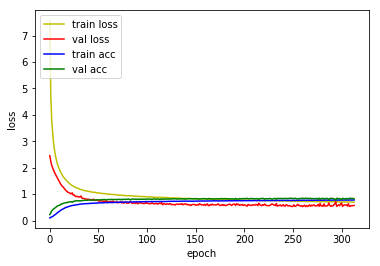

4815/4815 [==============================] - 3s 543us/sample - loss: 0.6157 - acc: 0.8120
Loss: 0.6156512848251458 Accuracy: 0.8120457

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 5.8527 - acc: 0.1046
Epoch 00001: val_loss improved from inf to 2.41069, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/001-2.4107.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 5.8528 - acc: 0.1046 - val_loss: 2.4107 - val_acc: 0.1926
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5398 - acc: 0.1397
Epoch 00002: val_loss improved from 2.41069 to 2.08064, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/002-2.0806.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 3.5397 - acc: 0.1397 - val_loss: 2.0806 - val_acc: 0.3652
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0123 - acc: 0.6747
Epoch 00023: val_loss improved from 0.72094 to 0.71864, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/023-0.7186.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.0124 - acc: 0.6747 - val_loss: 0.7186 - val_acc: 0.7966
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9988 - acc: 0.6843
Epoch 00024: val_loss improved from 0.71864 to 0.71090, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/024-0.7109.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.9988 - acc: 0.6843 - val_loss: 0.7109 - val_acc: 0.7973
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9708 - acc: 0.6934
Epoch 00025: val_loss improved from 0.71090 to 0.66215, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/025-

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7370 - acc: 0.7711
Epoch 00048: val_loss did not improve from 0.48033
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7370 - acc: 0.7711 - val_loss: 0.5242 - val_acc: 0.8463
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7246 - acc: 0.7756
Epoch 00049: val_loss improved from 0.48033 to 0.47426, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/049-0.4743.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7246 - acc: 0.7756 - val_loss: 0.4743 - val_acc: 0.8612
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7177 - acc: 0.7789
Epoch 00050: val_loss did not improve from 0.47426
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7177 - acc: 0.7788 - val_loss: 0.4987 - val_acc: 0.8600
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.6241 - acc: 0.8053
Epoch 00075: val_loss did not improve from 0.42587
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6243 - acc: 0.8053 - val_loss: 0.4569 - val_acc: 0.8626
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6284 - acc: 0.8065
Epoch 00076: val_loss did not improve from 0.42587
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6284 - acc: 0.8065 - val_loss: 0.4531 - val_acc: 0.8707
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6174 - acc: 0.8077
Epoch 00077: val_loss did not improve from 0.42587
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6175 - acc: 0.8077 - val_loss: 0.4319 - val_acc: 0.8735
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6168 - acc: 0.8106
Epoch 00078: val_loss did not improve from 0.42587
36805/36805 [========================

Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5531 - acc: 0.8277
Epoch 00103: val_loss improved from 0.39277 to 0.38986, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/103-0.3899.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5530 - acc: 0.8277 - val_loss: 0.3899 - val_acc: 0.8842
Epoch 104/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5511 - acc: 0.8288
Epoch 00104: val_loss improved from 0.38986 to 0.38761, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_4_conv_checkpoint/104-0.3876.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5510 - acc: 0.8289 - val_loss: 0.3876 - val_acc: 0.8828
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5508 - acc: 0.8288
Epoch 00105: val_loss did not improve from 0.38761
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5508 - acc: 0.828

Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5129 - acc: 0.8396
Epoch 00131: val_loss did not improve from 0.37616
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5131 - acc: 0.8396 - val_loss: 0.3857 - val_acc: 0.8831
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5107 - acc: 0.8391
Epoch 00132: val_loss did not improve from 0.37616
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5108 - acc: 0.8390 - val_loss: 0.3824 - val_acc: 0.8849
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5105 - acc: 0.8396
Epoch 00133: val_loss did not improve from 0.37616
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5105 - acc: 0.8396 - val_loss: 0.3958 - val_acc: 0.8849
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5059 - acc: 0.8420
Epoch 00134: val_loss improved from 0.37616 to 0.37481, saving model to

36800/36805 [============================>.] - ETA: 0s - loss: 0.4702 - acc: 0.8523
Epoch 00159: val_loss did not improve from 0.36415
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4703 - acc: 0.8522 - val_loss: 0.3961 - val_acc: 0.8814
Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4686 - acc: 0.8536
Epoch 00160: val_loss did not improve from 0.36415
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4685 - acc: 0.8536 - val_loss: 0.4163 - val_acc: 0.8744
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4655 - acc: 0.8543
Epoch 00161: val_loss did not improve from 0.36415
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4655 - acc: 0.8543 - val_loss: 0.3860 - val_acc: 0.8805
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4635 - acc: 0.8551
Epoch 00162: val_loss did not improve from 0.36415
36805/36805 [=====================

Epoch 188/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4428 - acc: 0.8591
Epoch 00188: val_loss did not improve from 0.35805
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4427 - acc: 0.8591 - val_loss: 0.3622 - val_acc: 0.8915
Epoch 189/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4413 - acc: 0.8614
Epoch 00189: val_loss did not improve from 0.35805
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4413 - acc: 0.8614 - val_loss: 0.3711 - val_acc: 0.8921
Epoch 190/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4351 - acc: 0.8641
Epoch 00190: val_loss did not improve from 0.35805
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4351 - acc: 0.8641 - val_loss: 0.3701 - val_acc: 0.8870
Epoch 191/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4426 - acc: 0.8600
Epoch 00191: val_loss did not improve from 0.35805
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.4145 - acc: 0.8693
Epoch 00217: val_loss did not improve from 0.35750
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4144 - acc: 0.8693 - val_loss: 0.3892 - val_acc: 0.8863
Epoch 218/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4160 - acc: 0.8691
Epoch 00218: val_loss did not improve from 0.35750
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4161 - acc: 0.8690 - val_loss: 0.3590 - val_acc: 0.8915
Epoch 219/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4107 - acc: 0.8700
Epoch 00219: val_loss did not improve from 0.35750
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.4107 - acc: 0.8700 - val_loss: 0.3586 - val_acc: 0.8938
Epoch 220/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4126 - acc: 0.8698
Epoch 00220: val_loss did not improve from 0.35750
36805/36805 [=====================

Epoch 247/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3890 - acc: 0.8764
Epoch 00247: val_loss did not improve from 0.35750
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.3890 - acc: 0.8763 - val_loss: 0.3722 - val_acc: 0.8928
Epoch 248/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3915 - acc: 0.8764
Epoch 00248: val_loss did not improve from 0.35750
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.3915 - acc: 0.8764 - val_loss: 0.3770 - val_acc: 0.8891
Epoch 249/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3896 - acc: 0.8769
Epoch 00249: val_loss did not improve from 0.35750
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.3897 - acc: 0.8769 - val_loss: 0.3939 - val_acc: 0.8852
Epoch 250/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4014 - acc: 0.8730
Epoch 00250: val_loss did not improve from 0.35750
36805/36805 [=======

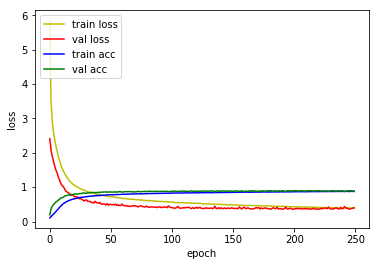

4815/4815 [==============================] - 3s 571us/sample - loss: 0.4237 - acc: 0.8698
Loss: 0.42367817113951606 Accuracy: 0.8697819

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.9130 - acc: 0.1490
Epoch 00001: val_loss improved from inf to 2.07288, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_5_conv_checkpoint/001-2.0729.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 4.9128 - acc: 0.1490 - val_loss: 2.0729 - val_acc: 0.3173
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1548 - acc: 0.2552
Epoch 00002: val_loss improved from 2.07288 to 1.50295, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_5_conv_checkpoint/002-1.5029.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 3.1548 - acc: 0.2552 - val_loss: 1.5029 - val_acc: 0.5532
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5083 - acc: 0.8433
Epoch 00024: val_loss improved from 0.31161 to 0.30875, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_5_conv_checkpoint/024-0.3087.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5085 - acc: 0.8433 - val_loss: 0.3087 - val_acc: 0.9113
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4995 - acc: 0.8441
Epoch 00025: val_loss improved from 0.30875 to 0.29542, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_5_conv_checkpoint/025-0.2954.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.4995 - acc: 0.8441 - val_loss: 0.2954 - val_acc: 0.9168
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4822 - acc: 0.8506
Epoch 00026: val_loss did not improve from 0.29542
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4822 - acc: 0.8506 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.3227 - acc: 0.9003
Epoch 00050: val_loss did not improve from 0.23088
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3228 - acc: 0.9003 - val_loss: 0.2396 - val_acc: 0.9348
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3263 - acc: 0.8990
Epoch 00051: val_loss did not improve from 0.23088
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3265 - acc: 0.8990 - val_loss: 0.2386 - val_acc: 0.9313
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3145 - acc: 0.9024
Epoch 00052: val_loss improved from 0.23088 to 0.22669, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_5_conv_checkpoint/052-0.2267.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.3145 - acc: 0.9025 - val_loss: 0.2267 - val_acc: 0.9320
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.311

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2403 - acc: 0.9253
Epoch 00078: val_loss did not improve from 0.20345
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2403 - acc: 0.9253 - val_loss: 0.2128 - val_acc: 0.9371
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2384 - acc: 0.9263
Epoch 00079: val_loss did not improve from 0.20345
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.2384 - acc: 0.9263 - val_loss: 0.2047 - val_acc: 0.9394
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2377 - acc: 0.9260
Epoch 00080: val_loss did not improve from 0.20345
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.2376 - acc: 0.9260 - val_loss: 0.2193 - val_acc: 0.9359
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9278
Epoch 00081: val_loss did not improve from 0.20345
36805/36805 [===========

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1962 - acc: 0.9390
Epoch 00107: val_loss did not improve from 0.19663
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1963 - acc: 0.9390 - val_loss: 0.2145 - val_acc: 0.9399
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1948 - acc: 0.9388
Epoch 00108: val_loss did not improve from 0.19663
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1948 - acc: 0.9387 - val_loss: 0.2003 - val_acc: 0.9387
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1869 - acc: 0.9417
Epoch 00109: val_loss did not improve from 0.19663
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.1868 - acc: 0.9417 - val_loss: 0.2036 - val_acc: 0.9427
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1884 - acc: 0.9402
Epoch 00110: val_loss did not improve from 0.19663
36805/36805 [=======

Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1534 - acc: 0.9528
Epoch 00137: val_loss did not improve from 0.19663
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1533 - acc: 0.9528 - val_loss: 0.2024 - val_acc: 0.9425
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1538 - acc: 0.9502
Epoch 00138: val_loss did not improve from 0.19663
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1538 - acc: 0.9501 - val_loss: 0.2267 - val_acc: 0.9373
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1530 - acc: 0.9513
Epoch 00139: val_loss did not improve from 0.19663
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1529 - acc: 0.9513 - val_loss: 0.2254 - val_acc: 0.9371
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1489 - acc: 0.9514
Epoch 00140: val_loss did not improve from 0.19663
36805/36805 [=======

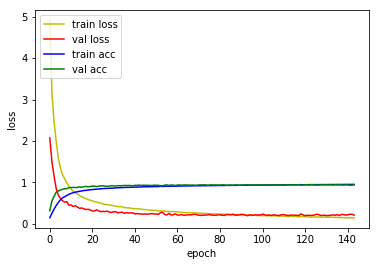

4815/4815 [==============================] - 3s 640us/sample - loss: 0.2370 - acc: 0.9238
Loss: 0.23701797800519633 Accuracy: 0.92377985

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.0090 - acc: 0.2100
Epoch 00001: val_loss improved from inf to 1.58583, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_6_conv_checkpoint/001-1.5858.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 4.0089 - acc: 0.2100 - val_loss: 1.5858 - val_acc: 0.5013
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1378 - acc: 0.4195
Epoch 00002: val_loss improved from 1.58583 to 0.73989, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_6_conv_checkpoint/002-0.7399.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.1377 - acc: 0.4196 - val_loss: 0.7399 - val_acc: 0.7789
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2787 - acc: 0.9140
Epoch 00025: val_loss improved from 0.16752 to 0.15739, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_6_conv_checkpoint/025-0.1574.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.2787 - acc: 0.9141 - val_loss: 0.1574 - val_acc: 0.9532
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2670 - acc: 0.9162
Epoch 00026: val_loss did not improve from 0.15739
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.2670 - acc: 0.9162 - val_loss: 0.1696 - val_acc: 0.9490
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2584 - acc: 0.9187
Epoch 00027: val_loss did not improve from 0.15739
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.2585 - acc: 0.9187 - val_loss: 0.1866 - val_acc: 0.9436
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1443 - acc: 0.9542
Epoch 00053: val_loss improved from 0.13643 to 0.13407, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_6_conv_checkpoint/053-0.1341.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1443 - acc: 0.9542 - val_loss: 0.1341 - val_acc: 0.9553
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1435 - acc: 0.9539
Epoch 00054: val_loss did not improve from 0.13407
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1435 - acc: 0.9539 - val_loss: 0.1385 - val_acc: 0.9553
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1404 - acc: 0.9563
Epoch 00055: val_loss did not improve from 0.13407
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1405 - acc: 0.9563 - val_loss: 0.1586 - val_acc: 0.9506
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0883 - acc: 0.9715
Epoch 00082: val_loss did not improve from 0.13071
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0883 - acc: 0.9716 - val_loss: 0.1556 - val_acc: 0.9562
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9715
Epoch 00083: val_loss did not improve from 0.13071
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0878 - acc: 0.9715 - val_loss: 0.1371 - val_acc: 0.9597
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9715
Epoch 00084: val_loss did not improve from 0.13071
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0879 - acc: 0.9715 - val_loss: 0.1405 - val_acc: 0.9574
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0869 - acc: 0.9723
Epoch 00085: val_loss did not improve from 0.13071
36805/36805 [===========

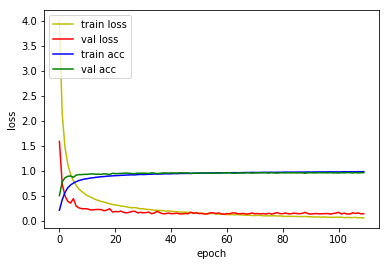

4815/4815 [==============================] - 3s 684us/sample - loss: 0.1666 - acc: 0.9502
Loss: 0.16661081556404864 Accuracy: 0.95015574

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.0130 - acc: 0.3117
Epoch 00001: val_loss improved from inf to 1.15885, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_7_conv_checkpoint/001-1.1589.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 3.0131 - acc: 0.3117 - val_loss: 1.1589 - val_acc: 0.6480
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3526 - acc: 0.6049
Epoch 00002: val_loss improved from 1.15885 to 0.40835, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_7_conv_checkpoint/002-0.4083.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.3525 - acc: 0.6049 - val_loss: 0.4083 - val_acc: 0.8777
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1491 - acc: 0.9530
Epoch 00025: val_loss improved from 0.12955 to 0.12589, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_7_conv_checkpoint/025-0.1259.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1491 - acc: 0.9530 - val_loss: 0.1259 - val_acc: 0.9616
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1398 - acc: 0.9545
Epoch 00026: val_loss did not improve from 0.12589
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1398 - acc: 0.9545 - val_loss: 0.1437 - val_acc: 0.9588
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9571
Epoch 00027: val_loss did not improve from 0.12589
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.1342 - acc: 0.9571 - val_loss: 0.1305 - val_acc: 0.9604
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9815
Epoch 00054: val_loss did not improve from 0.11647
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0571 - acc: 0.9815 - val_loss: 0.1521 - val_acc: 0.9576
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9840
Epoch 00055: val_loss did not improve from 0.11647
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0511 - acc: 0.9840 - val_loss: 0.1306 - val_acc: 0.9632
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0627 - acc: 0.9806
Epoch 00056: val_loss did not improve from 0.11647
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0627 - acc: 0.9806 - val_loss: 0.1378 - val_acc: 0.9602
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9862
Epoch 00057: val_loss did not improve from 0.11647
36805/36805 [===========


1D_CNN_custom_multi_2_GMP_DO_BN_7_conv Model


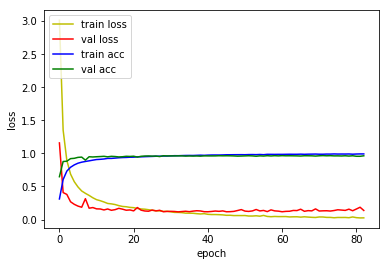

4815/4815 [==============================] - 3s 723us/sample - loss: 0.1475 - acc: 0.9535
Loss: 0.1475257602962254 Accuracy: 0.9534787

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3610 - acc: 0.3840
Epoch 00001: val_loss improved from inf to 0.99781, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_8_conv_checkpoint/001-0.9978.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.3610 - acc: 0.3841 - val_loss: 0.9978 - val_acc: 0.6867
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9819 - acc: 0.6999
Epoch 00002: val_loss improved from 0.99781 to 0.37722, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_DO_BN_8_conv_checkpoint/002-0.3772.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.9820 - acc: 0.6999 - val_loss: 0.3772 - val_acc: 0.8800
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0800 - acc: 0.9747
Epoch 00026: val_loss did not improve from 0.10917
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0800 - acc: 0.9747 - val_loss: 0.1195 - val_acc: 0.9653
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0745 - acc: 0.9762
Epoch 00027: val_loss did not improve from 0.10917
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0745 - acc: 0.9762 - val_loss: 0.1378 - val_acc: 0.9606
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9782
Epoch 00028: val_loss did not improve from 0.10917
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0689 - acc: 0.9782 - val_loss: 0.1193 - val_acc: 0.9625
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9801
Epoch 00029: val_loss did not improve from 0.10917
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9927
Epoch 00056: val_loss did not improve from 0.10917
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0236 - acc: 0.9927 - val_loss: 0.1346 - val_acc: 0.9653
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9927
Epoch 00057: val_loss did not improve from 0.10917
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0240 - acc: 0.9927 - val_loss: 0.1387 - val_acc: 0.9634
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9939
Epoch 00058: val_loss did not improve from 0.10917
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0206 - acc: 0.9938 - val_loss: 0.1547 - val_acc: 0.9667
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9905
Epoch 00059: val_loss did not improve from 0.10917
36805/36805 [===========

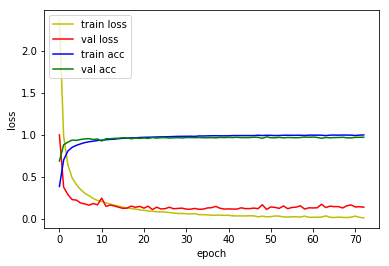

4815/4815 [==============================] - 4s 777us/sample - loss: 0.1693 - acc: 0.9483
Loss: 0.16933279489229897 Accuracy: 0.9482866



In [10]:
base = '1D_CNN_custom_multi_2_GMP_DO_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 754us/sample - loss: 0.4237 - acc: 0.8698
Loss: 0.42367817113951606 Accuracy: 0.8697819

1D_CNN_custom_multi_2_GMP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)

4815/4815 [==============================] - 4s 810us/sample - loss: 0.1666 - acc: 0.9502
Loss: 0.16661081556404864 Accuracy: 0.95015574

1D_CNN_custom_multi_2_GMP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation

4815/4815 [==============================] - 4s 870us/sample - loss: 0.1693 - acc: 0.9483
Loss: 0.16933279489229897 Accuracy: 0.9482866


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_DO_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_33 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_33[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 862us/sample - loss: 0.4482 - acc: 0.8675
Loss: 0.4481992211544873 Accuracy: 0.8674974

1D_CNN_custom_multi_2_GMP_DO_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation) 

4815/4815 [==============================] - 5s 988us/sample - loss: 0.1816 - acc: 0.9485
Loss: 0.18163802131066564 Accuracy: 0.9484943

1D_CNN_custom_multi_2_GMP_DO_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_51 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1869 - acc: 0.9589
Loss: 0.1869317456870509 Accuracy: 0.9588785
